In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam 
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Concatenate 
# Conv2D, Input, Flatten, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization

from keras.applications.vgg16 import VGG16

%matplotlib inline

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/home/kbujari/.local/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/kbujari/.local/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/kbujari/.local/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/hpc/sw/python-3.5.2/lib/python3.5/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/hpc/sw/python-3.5.2/lib/python3.5/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: libiomp5.so: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [3]:
from utils.preprocess import DataGenerator
from utils.callbacks import PlotCurves
from utils.load_data import load_data
from utils.comparams import auc

In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

### Data Generator

In [5]:
data_dir = './data/'

In [6]:
x_train, y_train, x_valid, y_valid = load_data(data_dir, purpose='train', 
                                               limit=1000, val_limit=32000, norm='macenko')
len(x_train), len(x_valid)

(1000, 32000)

In [7]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

In [8]:
del train_id
del val_id
del data_dir

## MODEL

In [9]:
def build_arch_8_net():
    
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(96,96,3))
    x = vgg16.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities
    model = Model(inputs=vgg16.input, outputs=y)
    
    # Train only the top layer
    for layer in vgg16.layers:
        layer.trainable = False

    return model

In [10]:
model = build_arch_8_net()

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0         
__________

### Compile

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000005)

In [13]:
optimizer = Adam(lr=0.001)
loss = 'binary_crossentropy'
metrics = ['acc', auc]

In [14]:
model.compile(optimizer, loss, metrics)

## Train the model

In [16]:
model_name = 'vgg16_model_bin_cross_arch_8_lr_0_001_inp96_on10k'

In [17]:
batch_size = 64
n_epoch = 10

# Parameters for generators
train_params = {
    'dim': (96, 96),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': True,
    'shuffle': True
}

val_params = {
    'dim': (96, 96),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': False,
    'shuffle': True
}

# Generators
training_generator = DataGenerator(partition['train'], x_train, train_labels, **train_params)
validation_generator = DataGenerator(partition['validation'], x_valid, val_labels, **val_params)


# Callbacks
callbacks = [PlotCurves(model_name=model_name), learning_rate_reduction]

In [18]:
del x_train
del x_valid
del y_train
del y_valid
del train_labels
del val_labels

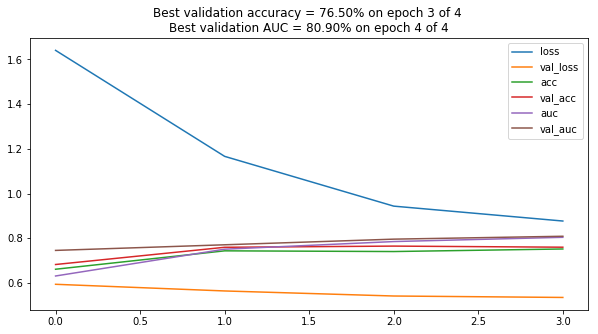

15/15 [==============================] - 171s 11s/step - loss: 0.8771 - acc: 0.7521 - auc: 0.8043 - val_loss: 0.5353 - val_acc: 0.7600 - val_auc: 0.8090
Epoch 5/10
14/15 [===========================>..] - ETA: 0s - loss: 0.8427 - acc: 0.7667 - auc: 0.8129

In [ ]:
# Training - limitless - macenko - augmented
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)